<a href="https://colab.research.google.com/github/8anisyamaura/Analisis_Ulasan_ChatGPT_App/blob/main/Klasifikasi%20Data/Klasifikasi_Model_Transformer(BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***TRANSFORMER (BERT)*** menggunakan BoW

In [1]:
import pandas as pd

file_path = 'label_manual.csv'
data = pd.read_csv(file_path, sep=';')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   normalisasi  248 non-null    object
 1   label        248 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


,normalisasi,label
0,luar biasa,positive
1,aplikasi nya bagus bisa serba guna tapi buat u...,neutral
2,good,positive
3,sangat membantu,positive
4,karena tidak sesuai dengan gambar,negative


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

cleaned_data = data.dropna(subset=['normalisasi'])

X = cleaned_data['normalisasi']
y = cleaned_data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))
print('===========================')

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")

def bert_encode(text_list, tokenizer, model, max_length=128):
    encoded = tokenizer(
        list(text_list),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(
            input_ids=encoded['input_ids'],
            attention_mask=encoded['attention_mask']
        )

    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embeddings

X_train_vec = bert_encode(X_train, tokenizer, bert_model)
X_test_vec = bert_encode(X_test, tokenizer, bert_model)

X_train_vec.shape, X_test_vec.shape

Jumlah data latih: 198
Jumlah data uji: 50


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

((198, 768), (50, 768))

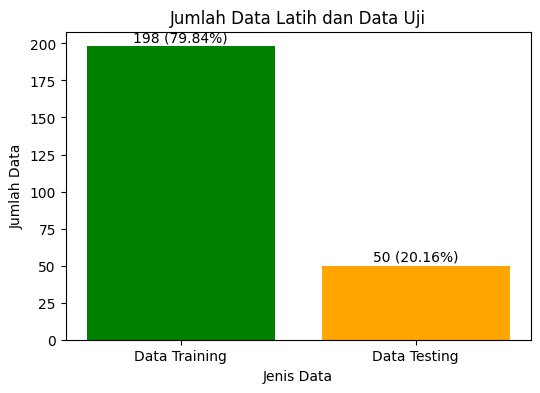

In [3]:
import matplotlib.pyplot as plt


train_size = len(X_train)
test_size = len(X_test)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Data Training', 'Data Testing'], [train_size, test_size], color=['green', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height} ({height / (train_size + test_size) * 100:.2f}%)',
             ha='center', va='bottom')

plt.title('Jumlah Data Latih dan Data Uji')
plt.xlabel('Jenis Data')
plt.ylabel('Jumlah Data')
plt.show()


In [4]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd


models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Decision Trees": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42, hidden_layer_sizes=(100,), max_iter=500),
}

results = {}

for model_name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    results[model_name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }



Confusion Matrix for SVM:


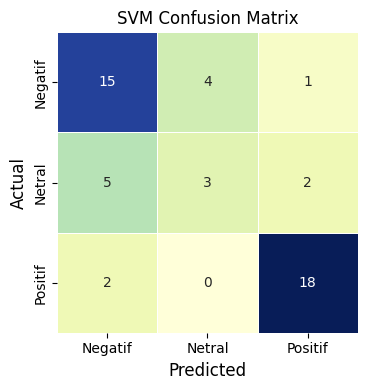


Confusion Matrix for KNN:


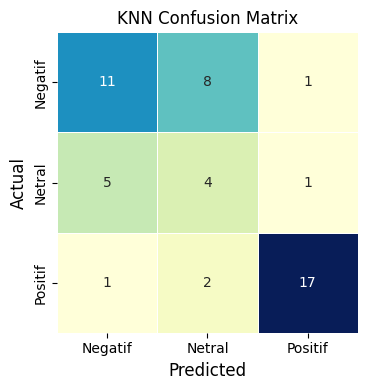


Confusion Matrix for Random Forest:


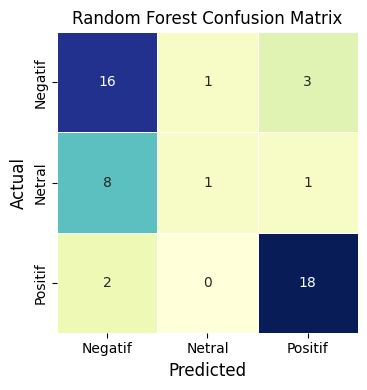


Confusion Matrix for Decision Trees:


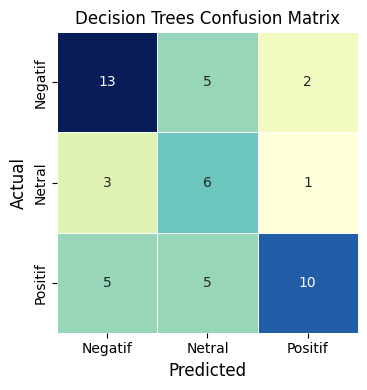


Confusion Matrix for Neural Network:


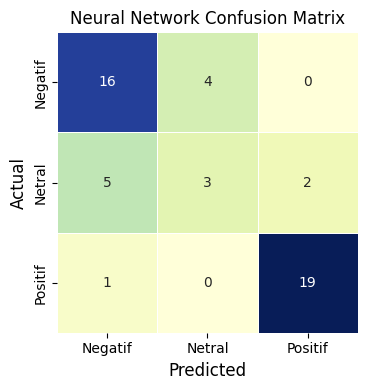

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, result in results.items():
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        result["confusion_matrix"],
        annot=True,
        fmt='d',
        cmap="YlGnBu",
        cbar=False,
        xticklabels=['Negatif', 'Netral', 'Positif'],
        yticklabels=['Negatif', 'Netral', 'Positif'],
        ax=ax,
        square=True,
        linewidths=0.5
    )

    print(f"\nConfusion Matrix for {model_name}:")
    ax.set_title(f"{model_name} Confusion Matrix", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)

    plt.tight_layout()
    plt.show()


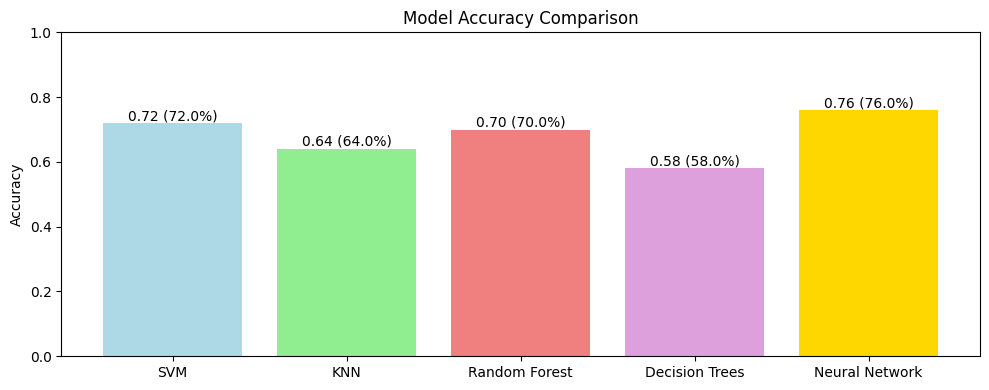

In [6]:
accuracies = {model: result['accuracy'] for model, result in results.items()}

plt.figure(figsize=(10, 4))
bars = plt.bar(
    list(accuracies.keys()),
    list(accuracies.values()),
    color=['lightblue', 'lightgreen', 'lightcoral', 'plum', 'gold']
)

for bar in bars:
    accuracy = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        accuracy,
        f'{accuracy:.2f} ({accuracy * 100:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [7]:
from IPython.display import display

for model_name, result in results.items():
    print(f"\nClassification Report for {model_name}:")

    report_df = pd.DataFrame(result['classification_report']).transpose()
    styled_df = report_df.style.background_gradient(cmap="coolwarm").format(precision=3)
    display(styled_df)



Classification Report for SVM:


,precision,recall,f1-score,support
negative,0.682,0.750,0.714,20.000
neutral,0.429,0.300,0.353,10.000
positive,0.857,0.900,0.878,20.000
accuracy,0.720,0.720,0.720,0.720
macro avg,0.656,0.650,0.648,50.000
weighted avg,0.701,0.720,0.708,50.000



Classification Report for KNN:


,precision,recall,f1-score,support
negative,0.647,0.550,0.595,20.000
neutral,0.286,0.400,0.333,10.000
positive,0.895,0.850,0.872,20.000
accuracy,0.640,0.640,0.640,0.640
macro avg,0.609,0.600,0.600,50.000
weighted avg,0.674,0.640,0.653,50.000



Classification Report for Random Forest:


,precision,recall,f1-score,support
negative,0.615,0.800,0.696,20.000
neutral,0.500,0.100,0.167,10.000
positive,0.818,0.900,0.857,20.000
accuracy,0.700,0.700,0.700,0.700
macro avg,0.645,0.600,0.573,50.000
weighted avg,0.673,0.700,0.654,50.000



Classification Report for Decision Trees:


,precision,recall,f1-score,support
negative,0.619,0.650,0.634,20.000
neutral,0.375,0.600,0.462,10.000
positive,0.769,0.500,0.606,20.000
accuracy,0.580,0.580,0.580,0.580
macro avg,0.588,0.583,0.567,50.000
weighted avg,0.630,0.580,0.588,50.000



Classification Report for Neural Network:


,precision,recall,f1-score,support
negative,0.727,0.800,0.762,20.000
neutral,0.429,0.300,0.353,10.000
positive,0.905,0.950,0.927,20.000
accuracy,0.760,0.760,0.760,0.760
macro avg,0.687,0.683,0.681,50.000
weighted avg,0.739,0.760,0.746,50.000
